# Graph Deep Learning on Graph to study Fake News

In [61]:
!pip install dgl

In [62]:
!pip install torch_geometric

^C
Traceback (most recent call last):
  File "/home/crvr/Ulm/M1/.venv/bin/pip", line 8, in <module>
    sys.exit(main())
             ^^^^^^
  File "/home/crvr/Ulm/M1/.venv/lib/python3.12/site-packages/pip/_internal/cli/main.py", line 78, in main
    command = create_command(cmd_name, isolated=("--isolated" in cmd_args))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/crvr/Ulm/M1/.venv/lib/python3.12/site-packages/pip/_internal/commands/__init__.py", line 114, in create_command
    module = importlib.import_module(module_path)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/importlib/__init__.py", line 90, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 1387, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1360, in _find_and_load
  File "<frozen importlib._bootstr

In [ ]:
from torch_geometric.datasets import UPFD
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, GCNConv, global_mean_pool
from torch.nn.modules import Linear
from torch_geometric.transforms import ToUndirected
from torch.functional import F
import torch
import argparse
import os.path as osp


The dataset is initialized there. Note that:
- `bert` is the result of a transformer on average tweeets of the author and other info from him/her (as in our article)
- `profile` (user profile info such as number of tweets, followers, and join date)
- `dataset` is either `politifact` or `gossipcop`

Hence this is the same datas as our article except that I struggle to understand their "Network and relations" embedding in our original paper: isn't it already in the edges in a message-passing strategy ?

In [94]:
from torch_geometric.data import DataLoader
from torch_geometric.datasets import UPFD
import os.path as osp
import torch

_file_ = '..'
file = _file_
dataset = 'gossipcop'  # or 'politifact'
path = osp.join(osp.dirname(osp.realpath(file)), '..', 'data', 'UPFD')

train_dataset_bert = UPFD(path, dataset, 'bert', 'train')
train_dataset_profile = UPFD(path, dataset, 'profile', 'train')
train_dataset_spacy = UPFD(path, dataset, "spacy", 'train')
train_dataset_content = UPFD(path, dataset, "content", "train")

val_dataset_bert = UPFD(path, dataset, 'bert', 'val')
val_dataset_profile = UPFD(path, dataset, 'profile', 'val')
val_dataset_spacy = UPFD(path, dataset, 'spacy', 'val')
val_dataset_content = UPFD(path, dataset, "content", "val")

test_dataset_bert = UPFD(path, dataset, 'bert', 'test')
test_dataset_profile = UPFD(path, dataset, 'profile', 'test')
test_dataset_spacy = UPFD(path, dataset, 'spacy', 'test')
test_dataset_content = UPFD(path, dataset, "content", "test")


def combine_features(*datasets):
    combined_data = []
    for data_list in zip(*datasets):
        combined_data_point = data_list[0].clone() 
        combined_features = torch.cat([data.x for data in data_list], dim=-1)  
        combined_data_point.x = combined_features  
        combined_data.append(combined_data_point)
    return combined_data


def create_dataset_with_profile():
    return train_dataset_profile, val_dataset_profile, test_dataset_profile

def create_random_dataset():
    train_rdm = [data.clone() for data in train_dataset_bert] 
    val_rdm = [data.clone() for data in val_dataset_bert]
    test_rdm = [data.clone() for data in test_dataset_bert]

    for e in train_rdm:
        e.x = torch.rand_like(e.x)
    for e in val_rdm:
        e.x = torch.rand_like(e.x)
    for e in test_rdm:
        e.x = torch.rand_like(e.x)

    return train_rdm, val_rdm, test_rdm


def create_dataset_with_profile_and_content():
    train_combined = combine_features(train_dataset_profile, train_dataset_content)
    val_combined = combine_features(val_dataset_profile, val_dataset_content)
    test_combined = combine_features(test_dataset_profile, test_dataset_content)
    return train_combined, val_combined, test_combined


def create_dataset_with_profile_bert_spacy():
    train_combined = combine_features(train_dataset_profile, train_dataset_bert, train_dataset_spacy)
    val_combined = combine_features(val_dataset_profile, val_dataset_bert, val_dataset_spacy)
    test_combined = combine_features(test_dataset_profile, test_dataset_bert, test_dataset_spacy)
    return train_combined, val_combined, test_combined


def create_dataset_with_all_features():
    train_combined = combine_features(train_dataset_profile, train_dataset_bert, train_dataset_spacy, train_dataset_content)
    val_combined = combine_features(val_dataset_profile, val_dataset_bert, val_dataset_spacy, val_dataset_content)
    test_combined = combine_features(test_dataset_profile, test_dataset_bert, test_dataset_spacy, test_dataset_content)
    return train_combined, val_combined, test_combined


train_dataset, val_dataset, test_dataset = create_dataset_with_all_features()

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Debugging: Print the length of features for the first graph
print(f"Number of total samples: {len(train_dataset) + len(val_dataset) + len(test_dataset)}")
print(f"Length for the model: {len(train_dataset[0].x[0])}")


Number of total samples: 5464
Length for the model: 1388


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
print(train_dataset_bert)
print(train_dataset[0].y)
print(train_dataset[0].x)
print(train_dataset[0].edge_index)
#train_dataset[i] représente l'arbre i
#Le champ x représente la valeur des noeud, il est de taille (n, 778).
#Le champ edge index représente les connexion dans l'abre. Il est de taille (2, n - 1). edge_index[0][i] est
#le père de edge_index[1][i]. En pratique, il se trouve que edge_index[1][i] est toujours un linespace, ce qui est possible
#Le champ y représente si c'est un graphe de fake news ou pas

UPFD(1092, name=gossipcop, feature=bert)
tensor([0])
tensor([[-0.0848, -0.2643, -0.2449,  ..., -0.0624,  0.0178,  0.0736],
        [ 0.1415, -0.0493, -0.1443,  ..., -0.0533, -0.0104,  0.0431],
        [-0.0319,  0.0562,  0.4386,  ..., -0.0069, -0.0540,  0.0620],
        ...,
        [ 0.0231,  0.1641,  0.0682,  ..., -0.0418, -0.0145,  0.0705],
        [-0.0714,  0.1860,  0.1526,  ..., -0.0289, -0.0128,  0.0473],
        [ 0.0569,  0.1775,  0.1596,  ..., -0.0256,  0.0195,  0.0659]])
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          1, 70, 74],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
     

### Model

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

@torch.no_grad()
def plot_roc_curve(loader, model):
    model.eval()

    all_preds = []
    all_labels = []
    
    for data in loader:
        data = data.to(device)
        logits = model(data.x, data.edge_index, data.batch)
        all_preds.append(logits.cpu())
        all_labels.append(data.y.cpu())
    
    all_preds = torch.cat(all_preds, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    one_hot_labels = torch.nn.functional.one_hot(all_labels, num_classes=all_preds.size(1)).float()
    for class_idx in range(all_preds.size(1)):
        if class_idx ==1: break
        fpr, tpr, _ = roc_curve(one_hot_labels[:, class_idx], all_preds[:, class_idx])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {class_idx} (AUC = {roc_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.4)
    plt.show()

In [ ]:
class Net(torch.nn.Module):
    """
    This is the same model as the article. They do not specify the dimensions of hidden channels so this is our choice.
    They do not specify the convolution method,  GCN seems to be the best.
    """
    def __init__(self, in_channels, hidden_channels, out_channels, concat=False):
        super().__init__()
        self.concat = concat
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        #self.conv1 = GATConv(in_channels, hidden_channels)
        #self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.mean_pooling = global_mean_pool
        self.lin1 = Linear(hidden_channels, 2 * hidden_channels)
        self.lin2 = Linear(2*hidden_channels,2)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = torch.nn.functional.selu(x)
        x = self.conv2(x, edge_index)
        x = torch.nn.functional.selu(x)
        x = self.mean_pooling(x, batch)
        x = torch.nn.functional.selu(x)
        x = self.lin1(x)
        x = torch.nn.functional.selu(x)
        x = self.lin2(x)
        return x.softmax(dim=-1)

In [ ]:
loss_fn = torch.nn.HingeEmbeddingLoss() # They specify that they want  the HingeEmbeddingLoss so we used it. 
device = 'cuda'
def train(model):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        y = torch.tensor([[1,0] if e==1 else [0,1] for e in data.y]).to(device)
        loss = loss_fn(out,y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs

    return total_loss / len(train_loader.dataset)

@torch.no_grad()
def test(loader, model):
    model.eval()

    total_correct = total_examples = 0
    for data in loader:
        data = data.to(device)
        pred = model(data.x, data.edge_index, data.batch).argmax(dim=-1)
        total_correct += int((pred ==
         data.y).sum())
        total_examples += data.num_graphs

    return total_correct / total_examples

### Ablation Study

In [83]:
# Only BERT
train_dataset,val_dataset,test_dataset = train_dataset_bert, val_dataset_bert, test_dataset_bert
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

inp_len = len(train_dataset[0].x[0])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modelBert = Net(inp_len, 128,train_dataset_bert.num_classes, concat=True).to(device)
optimizer = torch.optim.Adam(modelBert.parameters(), lr=5e-4,amsgrad=True)#, weight_decay=0.01) # They precise that they use a 5e-4 AMSGrad. here we add a bit of weight decay to avoid over-fitting.

/home/crvr/Ulm/M1/.venv/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [84]:
for epoch in range(1, 200):
    loss = train(modelBert)
    train_acc = test(train_loader, modelBert)
    val_acc = test(val_loader, modelBert)
    test_acc = test(test_loader, modelBert)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, 'f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 01, Loss: 0.7451, Train: 0.5101, Val: 0.4853, Test: 0.4992
Epoch: 02, Loss: 0.7377, Train: 0.5852, Val: 0.5696, Test: 0.5669
Epoch: 03, Loss: 0.6929, Train: 0.7289, Val: 0.7161, Test: 0.7067
Epoch: 04, Loss: 0.6510, Train: 0.7143, Val: 0.7088, Test: 0.6986
Epoch: 05, Loss: 0.6360, Train: 0.7564, Val: 0.7601, Test: 0.7290
Epoch: 06, Loss: 0.6357, Train: 0.7280, Val: 0.7143, Test: 0.6992
Epoch: 07, Loss: 0.6211, Train: 0.7747, Val: 0.7619, Test: 0.7386
Epoch: 08, Loss: 0.6152, Train: 0.7839, Val: 0.7747, Test: 0.7446
Epoch: 09, Loss: 0.6106, Train: 0.7491, Val: 0.7308, Test: 0.7167
Epoch: 10, Loss: 0.6228, Train: 0.8013, Val: 0.7875, Test: 0.7473
Epoch: 11, Loss: 0.6192, Train: 0.7573, Val: 0.7418, Test: 0.7196
Epoch: 12, Loss: 0.6087, Train: 0.8013, Val: 0.7857, Test: 0.7478
Epoch: 13, Loss: 0.6011, Train: 0.8168, Val: 0.7766, Test: 0.7559
Epoch: 14, Loss: 0.5979, Train: 0.8159, Val: 0.7784, Test: 0.7525
Epoch: 15, Loss: 0.5944, Train: 0.7720, Val: 0.7399, Test: 0.7193
Epoch: 16,

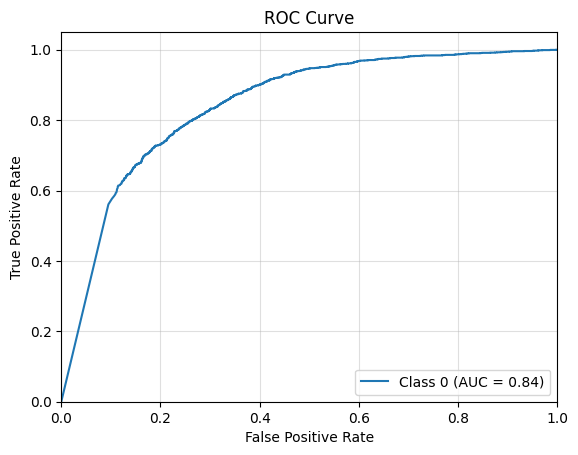

In [85]:
plot_roc_curve(test_loader,modelBert)


In [86]:
# Only BERT
train_dataset,val_dataset,test_dataset = train_dataset_spacy, val_dataset_spacy, test_dataset_spacy
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

inp_len = len(train_dataset[0].x[0])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modelSpacy = Net(inp_len, 128,train_dataset_bert.num_classes, concat=True).to(device)
optimizer = torch.optim.Adam(modelSpacy.parameters(), lr=5e-4,amsgrad=True)#, weight_decay=0.01) # They precise that they use a 5e-4 AMSGrad. here we add a bit of weight decay to avoid over-fitting.

/home/crvr/Ulm/M1/.venv/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [87]:
for epoch in range(1, 200):
    loss = train(modelSpacy)
    train_acc = test(train_loader, modelSpacy)
    val_acc = test(val_loader, modelSpacy)
    test_acc = test(test_loader, modelSpacy)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, 'f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 01, Loss: 0.7483, Train: 0.7170, Val: 0.7088, Test: 0.6845
Epoch: 02, Loss: 0.7355, Train: 0.6319, Val: 0.6227, Test: 0.6304
Epoch: 03, Loss: 0.7114, Train: 0.7079, Val: 0.7234, Test: 0.7073
Epoch: 04, Loss: 0.6789, Train: 0.7527, Val: 0.7546, Test: 0.7245
Epoch: 05, Loss: 0.6529, Train: 0.7363, Val: 0.7491, Test: 0.7209
Epoch: 06, Loss: 0.6385, Train: 0.7656, Val: 0.7747, Test: 0.7344
Epoch: 07, Loss: 0.6268, Train: 0.7527, Val: 0.7564, Test: 0.7316
Epoch: 08, Loss: 0.6223, Train: 0.7234, Val: 0.7253, Test: 0.7036
Epoch: 09, Loss: 0.6352, Train: 0.7518, Val: 0.7491, Test: 0.7360
Epoch: 10, Loss: 0.6149, Train: 0.7958, Val: 0.7985, Test: 0.7554
Epoch: 11, Loss: 0.6130, Train: 0.7839, Val: 0.7692, Test: 0.7593
Epoch: 12, Loss: 0.6112, Train: 0.8031, Val: 0.8114, Test: 0.7572
Epoch: 13, Loss: 0.6033, Train: 0.7985, Val: 0.7766, Test: 0.7648
Epoch: 14, Loss: 0.6039, Train: 0.7903, Val: 0.7711, Test: 0.7551
Epoch: 15, Loss: 0.5965, Train: 0.8187, Val: 0.7784, Test: 0.7687
Epoch: 16,

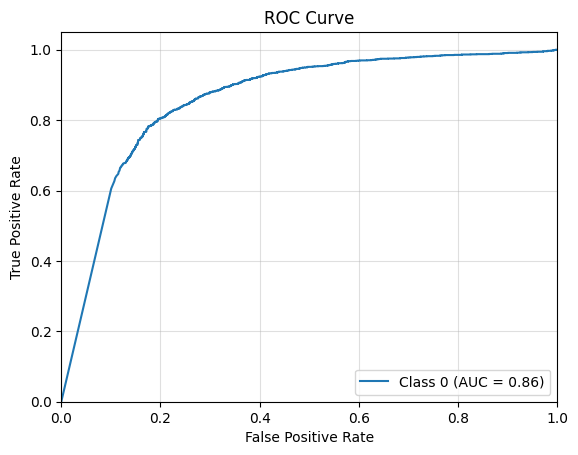

In [88]:
plot_roc_curve(test_loader,modelSpacy)


In [89]:
# Only content
train_dataset,val_dataset,test_dataset = train_dataset_content, val_dataset_content, test_dataset_content
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

inp_len = len(train_dataset[0].x[0])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modelContent = Net(inp_len, 128,train_dataset_bert.num_classes, concat=True).to(device)
optimizer = torch.optim.Adam(modelSpacy.parameters(), lr=5e-4,amsgrad=True)#, weight_decay=0.01) # They precise that they use a 5e-4 AMSGrad. here we add a bit of weight decay to avoid over-fitting.

/home/crvr/Ulm/M1/.venv/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [90]:
for epoch in range(1, 200):
    loss = train(modelContent)
    train_acc = test(train_loader, modelContent)
    val_acc = test(val_loader, modelContent)
    test_acc = test(test_loader, modelContent)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, 'f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 01, Loss: 0.7516, Train: 0.4789, Val: 0.4744, Test: 0.4720
Epoch: 02, Loss: 0.7516, Train: 0.4789, Val: 0.4744, Test: 0.4720
Epoch: 03, Loss: 0.7516, Train: 0.4789, Val: 0.4744, Test: 0.4720
Epoch: 04, Loss: 0.7516, Train: 0.4789, Val: 0.4744, Test: 0.4720
Epoch: 05, Loss: 0.7516, Train: 0.4789, Val: 0.4744, Test: 0.4720
Epoch: 06, Loss: 0.7516, Train: 0.4789, Val: 0.4744, Test: 0.4720
Epoch: 07, Loss: 0.7516, Train: 0.4789, Val: 0.4744, Test: 0.4720
Epoch: 08, Loss: 0.7516, Train: 0.4789, Val: 0.4744, Test: 0.4720
Epoch: 09, Loss: 0.7516, Train: 0.4789, Val: 0.4744, Test: 0.4720
Epoch: 10, Loss: 0.7516, Train: 0.4789, Val: 0.4744, Test: 0.4720
Epoch: 11, Loss: 0.7516, Train: 0.4789, Val: 0.4744, Test: 0.4720
Epoch: 12, Loss: 0.7516, Train: 0.4789, Val: 0.4744, Test: 0.4720
Epoch: 13, Loss: 0.7516, Train: 0.4789, Val: 0.4744, Test: 0.4720
Epoch: 14, Loss: 0.7516, Train: 0.4789, Val: 0.4744, Test: 0.4720
Epoch: 15, Loss: 0.7516, Train: 0.4789, Val: 0.4744, Test: 0.4720
Epoch: 16,

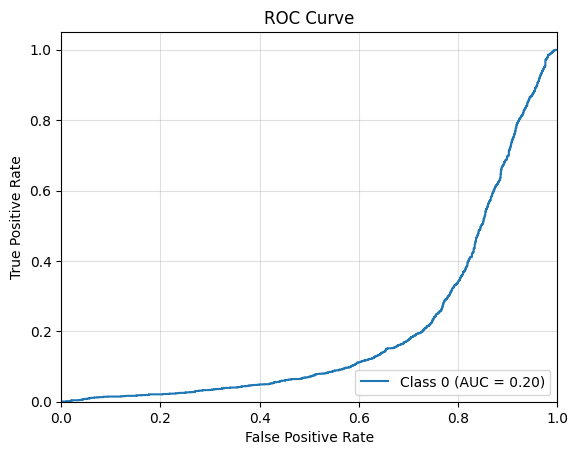

In [91]:
plot_roc_curve(test_loader,modelContent)


In [ ]:
# Only the user profile
train_dataset,val_dataset,test_dataset = create_dataset_with_profile()
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

inp_len = len(train_dataset[0].x[0])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model1 = Net(inp_len, 128,train_dataset_bert.num_classes, concat=True).to(device)
optimizer = torch.optim.Adam(model1.parameters(), lr=5e-4,amsgrad=True)#, weight_decay=0.01) # They precise that they use a 5e-4 AMSGrad. here we add a bit of weight decay to avoid over-fitting.

/home/crvr/Ulm/M1/.venv/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
for epoch in range(1, 200):
    loss = train(model1)
    train_acc = test(train_loader, model1)
    val_acc = test(val_loader, model1)
    test_acc = test(test_loader, model1)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, 'f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 01, Loss: 0.7382, Train: 0.5586, Val: 0.5495, Test: 0.5559
Epoch: 02, Loss: 0.7143, Train: 0.5980, Val: 0.6081, Test: 0.5920
Epoch: 03, Loss: 0.6984, Train: 0.6722, Val: 0.6886, Test: 0.6806
Epoch: 04, Loss: 0.6817, Train: 0.6877, Val: 0.6996, Test: 0.6950
Epoch: 05, Loss: 0.6675, Train: 0.7170, Val: 0.7289, Test: 0.7101
Epoch: 06, Loss: 0.6584, Train: 0.7161, Val: 0.7308, Test: 0.7177
Epoch: 07, Loss: 0.6532, Train: 0.7234, Val: 0.7363, Test: 0.7248
Epoch: 08, Loss: 0.6489, Train: 0.7308, Val: 0.7418, Test: 0.7313
Epoch: 09, Loss: 0.6402, Train: 0.7454, Val: 0.7527, Test: 0.7376
Epoch: 10, Loss: 0.6362, Train: 0.7527, Val: 0.7637, Test: 0.7426
Epoch: 11, Loss: 0.6310, Train: 0.7509, Val: 0.7637, Test: 0.7507
Epoch: 12, Loss: 0.6291, Train: 0.7692, Val: 0.7784, Test: 0.7543
Epoch: 13, Loss: 0.6203, Train: 0.7711, Val: 0.7875, Test: 0.7744
Epoch: 14, Loss: 0.6122, Train: 0.7967, Val: 0.8132, Test: 0.7953
Epoch: 15, Loss: 0.6056, Train: 0.8489, Val: 0.8388, Test: 0.8377
Epoch: 16,

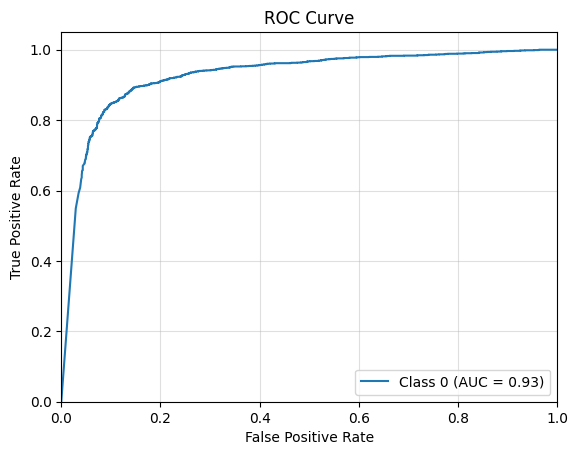

In [ ]:
plot_roc_curve(test_loader,model1)


In [ ]:
# Profile + content
train_dataset,val_dataset,test_dataset = create_dataset_with_profile_and_content()
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

inp_len = len(train_dataset[0].x[0])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model2 = Net(inp_len, 128,train_dataset_bert.num_classes, concat=True).to(device)
optimizer = torch.optim.Adam(model2.parameters(), lr=5e-4,amsgrad=True)#, weight_decay=0.01) # They precise that they use a 5e-4 AMSGrad. here we add a bit of weight decay to avoid over-fitting.

/home/crvr/Ulm/M1/.venv/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
for epoch in range(1, 200):
    loss = train(model2)
    train_acc = test(train_loader, model2)
    val_acc = test(val_loader, model2)
    test_acc = test(test_loader, model2)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, 'f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 01, Loss: 0.7492, Train: 0.5101, Val: 0.4853, Test: 0.4992
Epoch: 02, Loss: 0.7449, Train: 0.5101, Val: 0.4853, Test: 0.4992
Epoch: 03, Loss: 0.7449, Train: 0.5101, Val: 0.4853, Test: 0.4992
Epoch: 04, Loss: 0.7446, Train: 0.5101, Val: 0.4853, Test: 0.4992
Epoch: 05, Loss: 0.7378, Train: 0.7711, Val: 0.8022, Test: 0.7765
Epoch: 06, Loss: 0.7167, Train: 0.5833, Val: 0.5769, Test: 0.5815
Epoch: 07, Loss: 0.6795, Train: 0.6749, Val: 0.6923, Test: 0.6827
Epoch: 08, Loss: 0.6365, Train: 0.7170, Val: 0.7326, Test: 0.7198
Epoch: 09, Loss: 0.6153, Train: 0.8782, Val: 0.8993, Test: 0.8745
Epoch: 10, Loss: 0.5955, Train: 0.8095, Val: 0.7930, Test: 0.8129
Epoch: 11, Loss: 0.5865, Train: 0.9029, Val: 0.9286, Test: 0.9038
Epoch: 12, Loss: 0.5672, Train: 0.8755, Val: 0.8755, Test: 0.8704
Epoch: 13, Loss: 0.5626, Train: 0.8068, Val: 0.8114, Test: 0.7980
Epoch: 14, Loss: 0.6054, Train: 0.9203, Val: 0.9304, Test: 0.9239
Epoch: 15, Loss: 0.5674, Train: 0.9231, Val: 0.9322, Test: 0.9266
Epoch: 16,

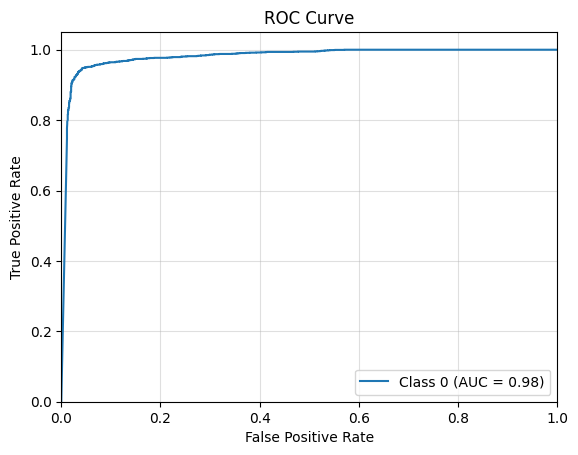

In [ ]:
plot_roc_curve(test_loader,model2)


In [ ]:
# Everything
train_dataset,val_dataset,test_dataset = create_dataset_with_all_features()
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

inp_len = len(train_dataset[0].x[0])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model3 = Net(inp_len, 128,train_dataset_bert.num_classes, concat=True).to(device)
optimizer = torch.optim.Adam(model3.parameters(), lr=5e-4,amsgrad=True)#, weight_decay=0.01) # They precise that they use a 5e-4 AMSGrad. here we add a bit of weight decay to avoid over-fitting.

In [ ]:
for epoch in range(1, 200):
    loss = train(model3)
    train_acc = test(train_loader, model3)
    val_acc = test(val_loader, model3)
    test_acc = test(test_loader, model3)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, 'f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 01, Loss: 0.7469, Train: 0.5101, Val: 0.4853, Test: 0.4992
Epoch: 02, Loss: 0.7444, Train: 0.5101, Val: 0.4853, Test: 0.4992
Epoch: 03, Loss: 0.7243, Train: 0.6337, Val: 0.6410, Test: 0.6124
Epoch: 04, Loss: 0.6785, Train: 0.7189, Val: 0.7436, Test: 0.7101
Epoch: 05, Loss: 0.6427, Train: 0.7656, Val: 0.7821, Test: 0.7585
Epoch: 06, Loss: 0.6213, Train: 0.7940, Val: 0.7985, Test: 0.7684
Epoch: 07, Loss: 0.6053, Train: 0.7995, Val: 0.7912, Test: 0.7637
Epoch: 08, Loss: 0.5971, Train: 0.8196, Val: 0.8114, Test: 0.7810
Epoch: 09, Loss: 0.5975, Train: 0.8288, Val: 0.8004, Test: 0.7820
Epoch: 10, Loss: 0.6024, Train: 0.7766, Val: 0.7564, Test: 0.7410
Epoch: 11, Loss: 0.5955, Train: 0.8535, Val: 0.8297, Test: 0.8082
Epoch: 12, Loss: 0.5806, Train: 0.7985, Val: 0.7930, Test: 0.7737
Epoch: 13, Loss: 0.5949, Train: 0.8452, Val: 0.8168, Test: 0.8032
Epoch: 14, Loss: 0.5770, Train: 0.8736, Val: 0.8443, Test: 0.8183
Epoch: 15, Loss: 0.5785, Train: 0.8672, Val: 0.8425, Test: 0.8231
Epoch: 16,

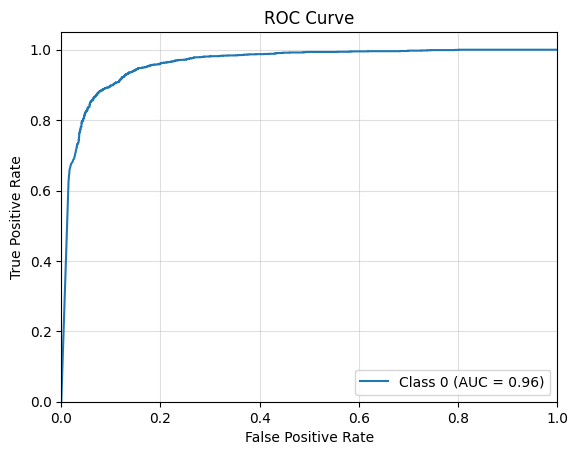

In [ ]:
plot_roc_curve(test_loader,model3)


In [ ]:
# User profile + user pref
train_dataset,val_dataset,test_dataset = create_dataset_with_profile_bert_spacy()
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

inp_len = len(train_dataset[0].x[0])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model4 = Net(inp_len, 128,train_dataset_bert.num_classes, concat=True).to(device)
optimizer = torch.optim.Adam(model4.parameters(), lr=5e-4,amsgrad=True)#, weight_decay=0.01) # They precise that they use a 5e-4 AMSGrad. here we add a bit of weight decay to avoid over-fitting.

/home/crvr/Ulm/M1/.venv/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [66]:
for epoch in range(1, 200):
    loss = train(model4)
    train_acc = test(train_loader, model4)
    val_acc = test(val_loader, model4)
    test_acc = test(test_loader, model4)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, 'f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 01, Loss: 0.7416, Train: 0.5705, Val: 0.5678, Test: 0.5596
Epoch: 02, Loss: 0.7042, Train: 0.7216, Val: 0.7161, Test: 0.7044
Epoch: 03, Loss: 0.6581, Train: 0.7189, Val: 0.6996, Test: 0.6997
Epoch: 04, Loss: 0.6376, Train: 0.7537, Val: 0.7381, Test: 0.7321
Epoch: 05, Loss: 0.6224, Train: 0.7756, Val: 0.7527, Test: 0.7378
Epoch: 06, Loss: 0.6197, Train: 0.7903, Val: 0.7766, Test: 0.7538
Epoch: 07, Loss: 0.6204, Train: 0.7509, Val: 0.7289, Test: 0.7203
Epoch: 08, Loss: 0.6242, Train: 0.7436, Val: 0.7198, Test: 0.7125
Epoch: 09, Loss: 0.6234, Train: 0.7729, Val: 0.7546, Test: 0.7337
Epoch: 10, Loss: 0.6151, Train: 0.8031, Val: 0.7839, Test: 0.7632
Epoch: 11, Loss: 0.6096, Train: 0.7857, Val: 0.7637, Test: 0.7475
Epoch: 12, Loss: 0.6141, Train: 0.7830, Val: 0.7692, Test: 0.7520
Epoch: 13, Loss: 0.6013, Train: 0.7930, Val: 0.7601, Test: 0.7520
Epoch: 14, Loss: 0.5998, Train: 0.8123, Val: 0.7711, Test: 0.7577
Epoch: 15, Loss: 0.5940, Train: 0.8114, Val: 0.7784, Test: 0.7640
Epoch: 16,

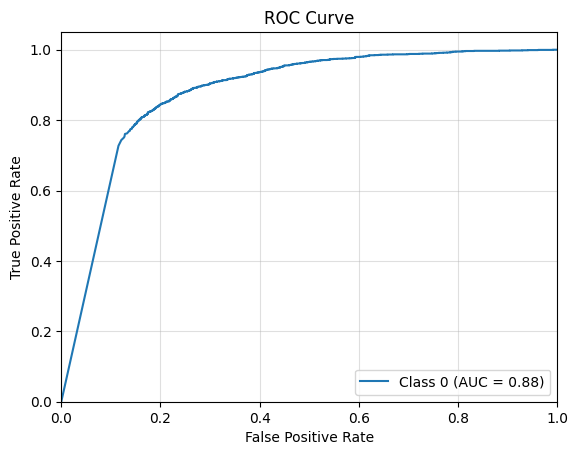

In [67]:
plot_roc_curve(test_loader,model4)


In [95]:
# Full random
# Everything
train_dataset,val_dataset,test_dataset = create_random_dataset()
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

inp_len = len(train_dataset[0].x[0])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modelR = Net(inp_len, 128,train_dataset_bert.num_classes, concat=True).to(device)
optimizer = torch.optim.Adam(modelR.parameters(), lr=5e-4,amsgrad=True)#, weight_decay=0.01) # They precise that they use a 5e-4 AMSGrad. here we add a bit of weight decay to avoid over-fitting.
for epoch in range(1, 200):
    loss = train(modelR)
    train_acc = test(train_loader, modelR)
    val_acc = test(val_loader, modelR)
    test_acc = test(test_loader, modelR)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, 'f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 01, Loss: 0.7536, Train: 0.5101, Val: 0.4853, Test: 0.4992
Epoch: 02, Loss: 0.7441, Train: 0.5101, Val: 0.4853, Test: 0.4992
Epoch: 03, Loss: 0.7440, Train: 0.5101, Val: 0.4853, Test: 0.4992
Epoch: 04, Loss: 0.7384, Train: 0.4908, Val: 0.5147, Test: 0.5008
Epoch: 05, Loss: 0.7415, Train: 0.5101, Val: 0.4853, Test: 0.4992
Epoch: 06, Loss: 0.7446, Train: 0.5101, Val: 0.4853, Test: 0.4992
Epoch: 07, Loss: 0.7450, Train: 0.5101, Val: 0.4853, Test: 0.4992
Epoch: 08, Loss: 0.7450, Train: 0.5101, Val: 0.4853, Test: 0.4992
Epoch: 09, Loss: 0.7450, Train: 0.5101, Val: 0.4853, Test: 0.4992
Epoch: 10, Loss: 0.7450, Train: 0.5101, Val: 0.4853, Test: 0.4992
Epoch: 11, Loss: 0.7450, Train: 0.5101, Val: 0.4853, Test: 0.4992
Epoch: 12, Loss: 0.7450, Train: 0.5101, Val: 0.4853, Test: 0.4992
Epoch: 13, Loss: 0.7450, Train: 0.5101, Val: 0.4853, Test: 0.4992
Epoch: 14, Loss: 0.7450, Train: 0.5101, Val: 0.4853, Test: 0.4992
Epoch: 15, Loss: 0.7450, Train: 0.5101, Val: 0.4853, Test: 0.4992
Epoch: 16,

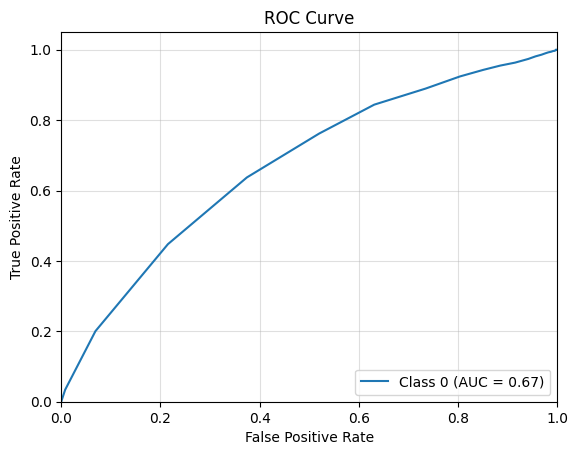

In [96]:
plot_roc_curve(test_loader,modelR)


### Adding Weight Decay

In [70]:
# Only the user profile
train_dataset,val_dataset,test_dataset = create_dataset_with_profile()
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

inp_len = len(train_dataset[0].x[0])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model1 = Net(inp_len, 128,train_dataset_bert.num_classes, concat=True).to(device)
optimizer = torch.optim.Adam(model1.parameters(), lr=5e-4,amsgrad=True, weight_decay=0.01) # They precise that they use a 5e-4 AMSGrad. here we add a bit of weight decay to avoid over-fitting.

In [71]:
for epoch in range(1, 200):
    loss = train(model1)
    train_acc = test(train_loader, model1)
    val_acc = test(val_loader, model1)
    test_acc = test(test_loader, model1)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, 'f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 01, Loss: 0.7458, Train: 0.5696, Val: 0.5659, Test: 0.5651
Epoch: 02, Loss: 0.7328, Train: 0.5696, Val: 0.5659, Test: 0.5653
Epoch: 03, Loss: 0.7237, Train: 0.5668, Val: 0.5733, Test: 0.5685
Epoch: 04, Loss: 0.7166, Train: 0.5742, Val: 0.5897, Test: 0.5813
Epoch: 05, Loss: 0.7098, Train: 0.6209, Val: 0.6410, Test: 0.6234
Epoch: 06, Loss: 0.7021, Train: 0.6429, Val: 0.6648, Test: 0.6479
Epoch: 07, Loss: 0.6936, Train: 0.6868, Val: 0.7106, Test: 0.6918
Epoch: 08, Loss: 0.6848, Train: 0.7005, Val: 0.7179, Test: 0.7033
Epoch: 09, Loss: 0.6759, Train: 0.7152, Val: 0.7234, Test: 0.7162
Epoch: 10, Loss: 0.6683, Train: 0.7207, Val: 0.7363, Test: 0.7211
Epoch: 11, Loss: 0.6630, Train: 0.7234, Val: 0.7436, Test: 0.7253
Epoch: 12, Loss: 0.6613, Train: 0.7308, Val: 0.7418, Test: 0.7245
Epoch: 13, Loss: 0.6580, Train: 0.7299, Val: 0.7418, Test: 0.7290
Epoch: 14, Loss: 0.6566, Train: 0.7308, Val: 0.7454, Test: 0.7284
Epoch: 15, Loss: 0.6530, Train: 0.7408, Val: 0.7564, Test: 0.7368
Epoch: 16,

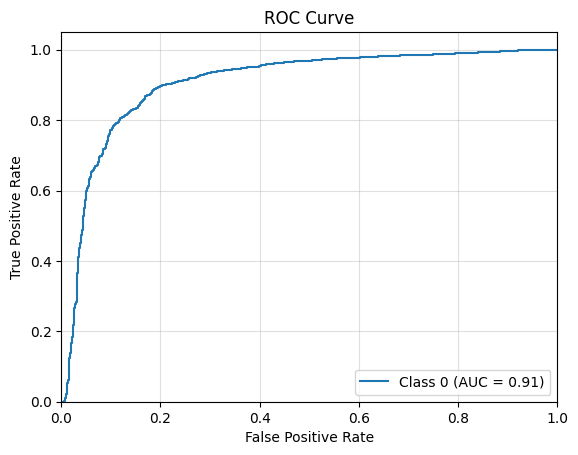

In [72]:
plot_roc_curve(test_loader,model1)


In [73]:
# Profile + content
train_dataset,val_dataset,test_dataset = create_dataset_with_profile_and_content()
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

inp_len = len(train_dataset[0].x[0])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model2 = Net(inp_len, 128,train_dataset_bert.num_classes, concat=True).to(device)
optimizer = torch.optim.Adam(model2.parameters(), lr=5e-4,amsgrad=True, weight_decay=0.01) # They precise that they use a 5e-4 AMSGrad. here we add a bit of weight decay to avoid over-fitting.

/home/crvr/Ulm/M1/.venv/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [74]:
for epoch in range(1, 200):
    loss = train(model2)
    train_acc = test(train_loader, model2)
    val_acc = test(val_loader, model2)
    test_acc = test(test_loader, model2)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, 'f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 01, Loss: 0.7499, Train: 0.5101, Val: 0.4853, Test: 0.4992
Epoch: 02, Loss: 0.7419, Train: 0.5101, Val: 0.4853, Test: 0.4992
Epoch: 03, Loss: 0.7391, Train: 0.5101, Val: 0.4853, Test: 0.4992
Epoch: 04, Loss: 0.7277, Train: 0.5852, Val: 0.5659, Test: 0.5815
Epoch: 05, Loss: 0.7105, Train: 0.5540, Val: 0.5256, Test: 0.5478
Epoch: 06, Loss: 0.6858, Train: 0.8645, Val: 0.8846, Test: 0.8643
Epoch: 07, Loss: 0.6568, Train: 0.8599, Val: 0.8571, Test: 0.8602
Epoch: 08, Loss: 0.6378, Train: 0.8544, Val: 0.8516, Test: 0.8542
Epoch: 09, Loss: 0.6108, Train: 0.8819, Val: 0.9066, Test: 0.8787
Epoch: 10, Loss: 0.5984, Train: 0.8068, Val: 0.8077, Test: 0.7862
Epoch: 11, Loss: 0.5862, Train: 0.8929, Val: 0.9212, Test: 0.8941
Epoch: 12, Loss: 0.5698, Train: 0.9148, Val: 0.9359, Test: 0.9143
Epoch: 13, Loss: 0.5694, Train: 0.8874, Val: 0.8956, Test: 0.8800
Epoch: 14, Loss: 0.5623, Train: 0.9423, Val: 0.9359, Test: 0.9373
Epoch: 15, Loss: 0.5507, Train: 0.9432, Val: 0.9414, Test: 0.9383
Epoch: 16,

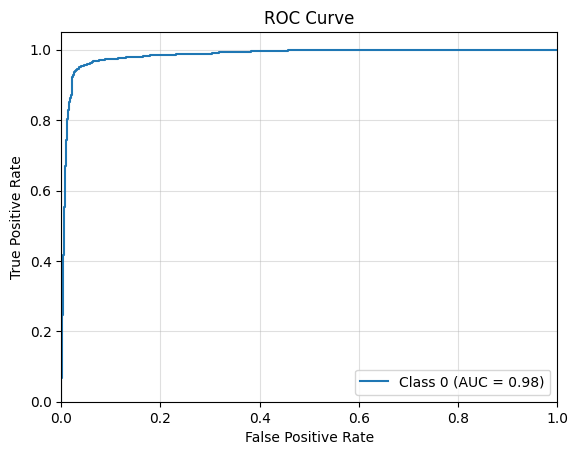

In [75]:
plot_roc_curve(test_loader,model2)


In [76]:
# Everything
train_dataset,val_dataset,test_dataset = create_dataset_with_all_features()
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

inp_len = len(train_dataset[0].x[0])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model3 = Net(inp_len, 128,train_dataset_bert.num_classes, concat=True).to(device)
optimizer = torch.optim.Adam(model3.parameters(), lr=5e-4,amsgrad=True, weight_decay=0.01) # They precise that they use a 5e-4 AMSGrad. here we add a bit of weight decay to avoid over-fitting.

/home/crvr/Ulm/M1/.venv/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [77]:
for epoch in range(1, 200):
    loss = train(model3)
    train_acc = test(train_loader, model3)
    val_acc = test(val_loader, model3)
    test_acc = test(test_loader, model3)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, 'f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 01, Loss: 0.7468, Train: 0.5101, Val: 0.4853, Test: 0.4992
Epoch: 02, Loss: 0.7439, Train: 0.5101, Val: 0.4853, Test: 0.4992
Epoch: 03, Loss: 0.7400, Train: 0.5604, Val: 0.5385, Test: 0.5546
Epoch: 04, Loss: 0.7270, Train: 0.6841, Val: 0.6758, Test: 0.6694
Epoch: 05, Loss: 0.6859, Train: 0.7711, Val: 0.7857, Test: 0.7593
Epoch: 06, Loss: 0.6427, Train: 0.7885, Val: 0.7875, Test: 0.7739
Epoch: 07, Loss: 0.6263, Train: 0.8205, Val: 0.8004, Test: 0.7828
Epoch: 08, Loss: 0.6088, Train: 0.7537, Val: 0.7582, Test: 0.7318
Epoch: 09, Loss: 0.6176, Train: 0.8013, Val: 0.7857, Test: 0.7731
Epoch: 10, Loss: 0.5961, Train: 0.8480, Val: 0.8223, Test: 0.8063
Epoch: 11, Loss: 0.5918, Train: 0.8407, Val: 0.8223, Test: 0.8032
Epoch: 12, Loss: 0.5876, Train: 0.8626, Val: 0.8516, Test: 0.8257
Epoch: 13, Loss: 0.5847, Train: 0.8874, Val: 0.8443, Test: 0.8377
Epoch: 14, Loss: 0.5778, Train: 0.7894, Val: 0.7857, Test: 0.7530
Epoch: 15, Loss: 0.6170, Train: 0.8452, Val: 0.8297, Test: 0.8095
Epoch: 16,

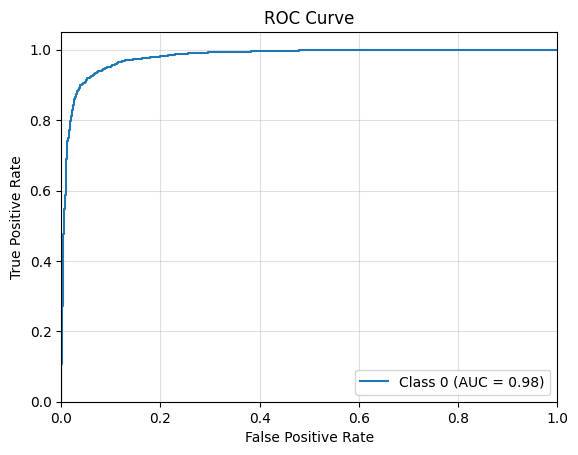

In [78]:
plot_roc_curve(test_loader,model3)


In [79]:
# User profile + user pref
train_dataset,val_dataset,test_dataset = create_dataset_with_profile_bert_spacy()
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

inp_len = len(train_dataset[0].x[0])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model4 = Net(inp_len, 128,train_dataset_bert.num_classes, concat=True).to(device)
optimizer = torch.optim.Adam(model4.parameters(), lr=5e-4,amsgrad=True, weight_decay=0.01) # They precise that they use a 5e-4 AMSGrad. here we add a bit of weight decay to avoid over-fitting.

/home/crvr/Ulm/M1/.venv/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [80]:
for epoch in range(1, 200):
    loss = train(model4)
    train_acc = test(train_loader, model4)
    val_acc = test(val_loader, model4)
    test_acc = test(test_loader, model4)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, 'f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 01, Loss: 0.7543, Train: 0.6108, Val: 0.5861, Test: 0.6025
Epoch: 02, Loss: 0.7373, Train: 0.5101, Val: 0.4853, Test: 0.4995
Epoch: 03, Loss: 0.7247, Train: 0.5751, Val: 0.5696, Test: 0.5549
Epoch: 04, Loss: 0.7097, Train: 0.7106, Val: 0.7143, Test: 0.6958
Epoch: 05, Loss: 0.6741, Train: 0.7344, Val: 0.7436, Test: 0.7337
Epoch: 06, Loss: 0.6460, Train: 0.7546, Val: 0.7637, Test: 0.7467
Epoch: 07, Loss: 0.6322, Train: 0.7509, Val: 0.7363, Test: 0.7232
Epoch: 08, Loss: 0.6314, Train: 0.7848, Val: 0.7711, Test: 0.7405
Epoch: 09, Loss: 0.6181, Train: 0.8022, Val: 0.7894, Test: 0.7582
Epoch: 10, Loss: 0.6130, Train: 0.7976, Val: 0.7821, Test: 0.7601
Epoch: 11, Loss: 0.6099, Train: 0.8114, Val: 0.7967, Test: 0.7656
Epoch: 12, Loss: 0.6052, Train: 0.8196, Val: 0.7802, Test: 0.7595
Epoch: 13, Loss: 0.6090, Train: 0.8223, Val: 0.7912, Test: 0.7726
Epoch: 14, Loss: 0.6025, Train: 0.7848, Val: 0.7509, Test: 0.7378
Epoch: 15, Loss: 0.6076, Train: 0.8260, Val: 0.7949, Test: 0.7731
Epoch: 16,

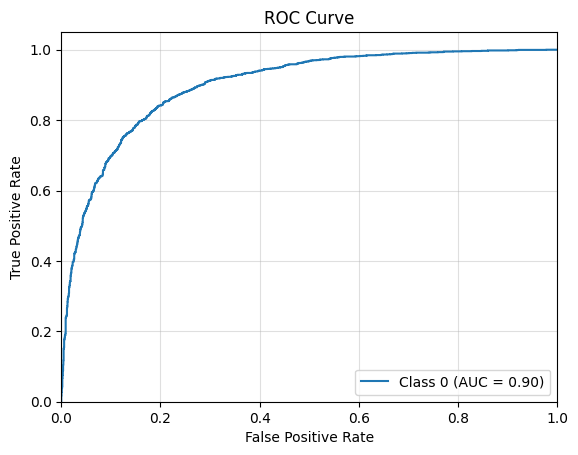

In [82]:
plot_roc_curve(test_loader,model4)
